In [1]:
# https://docs.python.org/3/library/sys.html
import sys
# https://docs.python.org/3/library/hashlib.html#hash-algorithms
import hashlib
# https://pymultihash.readthedocs.io/en/latest/#
import multihash
# https://py-multicodec.readthedocs.io/en/stable/
from multicodec import add_prefix, remove_prefix, get_codec
# https://github.com/multiformats/py-multibase
import multibase
# https://github.com/parrt/lolviz
from lolviz import *
# https://github.com/parrt/lolviz#preferencess
prefs.max_str_len = 64
# https://github.com/parrt/lolviz/blob/master/examples.ipynb
from IPython.display import display
# https://bitstring.readthedocs.io/en/latest/index.html
from bitstring import Bits, BitArray, BitStream, ConstBitStream
# https://github.com/ilanschnell/bitarray
from bitarray import bitarray
from bitarray.util import int2ba, ba2int, strip
# https://github.com/multiformats/unsigned-varint
import varint
# https://github.com/tqdm/tqdm
from tqdm import tqdm

In [2]:
# минимально необходимая длина для переданного целого
def bitLen(intValue):
    # работаем только с положительными целыми числами
    if intValue < 0:
        raise Exception("Only unsigned integers allowed")
    # для представления нуля все равно нужен 1 бит
    if intValue == 0:
        return 1
    length = 0
    while (intValue):
        intValue >>= 1
        length += 1
    return(length)

for i in range(17):
     print(i, ':', bitLen(i))

# compute hash block bytes or load it from menory
def getHashBlock(nounce, type="sha512"):
    nounceHash = hashlib.sha512(varint.encode(nounce)).digest()
    return Bits(bytes=nounceHash)

print(getHashBlock(1), len(getHashBlock(1)))
print(getHashBlock(2), len(getHashBlock(2)))

# вычислить два соседних блока хешей - чтобы можно было искать значения которые находятся на стыке блоков
def getExtendedHashBlock(nounce, type="sha512"):
    currentBlock = getHashBlock(nounce, type)
    nextBlock    = getHashBlock(nounce + 1, type)
    # prevBlock    = getHashBlock(nounce - 1, type)
    return (currentBlock + nextBlock)
print(getExtendedHashBlock(1), len(getExtendedHashBlock(1)))

# получить часть пространства хешей двух соседних блоков в котором может находится указанное значение
def getSearchHashBlock(nounce, value):
    valueLength  = len(value)
    blockLength  = 512
    hashBlock = getExtendedHashBlock(nounce)
    # получаем длину пространства хешей двух смежных блоков в котором может располагаться значение
    searchLength = blockLength + valueLength - 1
    return hashBlock[0:searchLength]

# найти значение битовой последовательности внутри блока
def findValueInBlock(nounce, value, count=1, normalize=False, bytealigned=False, start=0):
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # добавляем несколько бит из соседнего блока чтобы можно было искать значения на стыке блоков
    hashBlock = getSearchHashBlock(nounce, value)
    return list(hashBlock.findall(value, start=start, count=count, bytealigned=bytealigned))

testSearchHashBlock = getSearchHashBlock(1, Bits('0x39fa'))
print(testSearchHashBlock, len(testSearchHashBlock))
testFindValueInBlock = findValueInBlock(1, Bits('0x39fa'))
print(testFindValueInBlock)
print(Bits('0x39fa').bin, len(Bits('0x39fa')))

# получить значение из блока хешей
def readValueFromBlock(nounce, start, length):
    end = start + length
    hashBlock = getExtendedHashBlock(nounce)
    return hashBlock[start:end]

testValueStartsBlock1EndsBlock2 = Bits('0x39fa') 
print(testValueStartsBlock1EndsBlock2)
print(readValueFromBlock(1, 504, 16))

0 : 1
1 : 1
2 : 2
3 : 2
4 : 3
5 : 3
6 : 3
7 : 3
8 : 4
9 : 4
10 : 4
11 : 4
12 : 4
13 : 4
14 : 4
15 : 4
16 : 5
0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339 512
0xfab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f69dcca 512
0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f... 1024
0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab, 0b100 527
[504]
0011100111111010 16
0x39fa
0x39fa


In [3]:
# найти значение в пространстве хешей, в рамках указанного диапазона блоков
# эта функция возвращает все позиции бит в блоке, с которых начинается переданное значение
def findValueInHashes(value, fromNounce, toNounce, normalize=False, bytealigned=False):
    # сохраняем переданное значение и его длину до нормализации
    inputValue       = Bits(value)
    inputValueLength = len(inputValue)
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # вычисляем длину найденного значения чтобы корректно вычислить координаты для чтения
    valueLength = len(value)
    # размер одного блока хеша в битах
    blockSize     = 512
    # количество просмотренных блоков
    blocksProcessed = 0
    for nounce in tqdm(range(fromNounce, toNounce)):
        # ищем значение в блоке
        startPositions  = findValueInBlock(nounce, value, normalize=normalize, bytealigned=bytealigned)
        blocksProcessed = blocksProcessed + 1
        # возвращаем координаты значения если оно присутствует в блоке
        if (len(startPositions) > 0):
            # абсолютное смещение внутри пространства хещей от первого блока (в битах)
            offset = blockSize * nounce
            # номер первого бита значения внутри блока
            start  = startPositions[0]
            # номер последнего бита значения внутри блока
            end    = start + valueLength
            # абсолютный адрес начала и конца последовательности в битах, начиная от 0
            absoluteStart = offset + start
            absoluteEnd   = offset + end
            return {
                "success": True,
                "nounce":  nounce,
                "start":   start,
                "end":     end,
                "length":  valueLength,
                "meta": {
                    "value":            value,
                    "valueLength":      valueLength,
                    # "inputValue":       inputValue,
                    # "inputValueLength": inputValueLength,
                    "absoluteStart":    absoluteStart,
                    "absoluteEnd":      absoluteEnd,
                    "offset":           offset,
                    "fromNounce":       fromNounce,
                    "toNounce":         toNounce,
                    "blocksProcessed":  blocksProcessed,
                    "allPositions":     startPositions,
                    "valuesFound":      len(startPositions),
                }
            }
    return {
        "success": False,
        "meta": {
            "value":            value,
            "valueLength":      valueLength,
            # "inputValue":       inputValue,
            # "inputValueLength": inputValueLength,
            "fromNounce":       fromNounce,
            "toNounce":         toNounce,
            "blocksProcessed":  blocksProcessed,
            "valuesFound":      0,
        }
    }

  0%|          | 0/65535 [00:00<?, ?it/s]


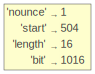

In [4]:
# создать указатель на найденное значение
def createPointerToValue(valueData):
    if (valueData["success"] == False):
        raise Exception("Pointer cannot be created: value not found")
    return {
        "nounce": valueData["nounce"],
        "start":  valueData["start"],
        "length": valueData["length"],
        "bit":    valueData["meta"]["absoluteStart"],
    }

testValueInHashes = findValueInHashes(Bits('0x39fa'), 1, 2**16)
testCreatePointerToValue = createPointerToValue(testValueInHashes)
display(objviz(testCreatePointerToValue))

In [11]:
def parseBitPosition(bitPosition):
    """
    Get hash block nounce, and byte-aligned position from absolute bit position
    """
    bytePosition = bitPosition // 8
    nounce       = bitPosition // 512
    blockBit     = bitPosition % 512
    blockByte    = blockBit // 8
    return {
        "bit": bitPosition,
        "byte": bytePosition,
        "start": blockBit,
        "blockBit": blockBit,
        "blockByte": blockByte,
        "nounce": nounce
    }

def parseBytePosition(bytePosition):
    """
    Get hash block nounce, and byte-aligned position from absolute byte position
    """
    bitPosition = bytePosition * 8
    return parseBitPosition(bitPosition)

testParseBitPosition1 = parseBitPosition(535)
print(testParseBitPosition1)
testParseBitPosition1 = parseBitPosition(5002481)
print(testParseBitPosition1)
testParseBytePosition = parseBytePosition(66)
print(testParseBytePosition)

{'bit': 535, 'byte': 66, 'start': 23, 'blockBit': 23, 'blockByte': 2, 'nounce': 1}
{'bit': 5002481, 'byte': 625310, 'start': 241, 'blockBit': 241, 'blockByte': 30, 'nounce': 9770}
{'bit': 528, 'byte': 66, 'start': 16, 'blockBit': 16, 'blockByte': 2, 'nounce': 1}


In [12]:
def readBitPosition(bitPosition, length):
    """
    Read bits from hash space
    """
    cursor = parseBitPosition(bitPosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], length)

testBitPositionValue = Bits('0xde')
testAbsoluteBitPosition = findValueInHashes(testBitPositionValue, 0, 512)["meta"]["absoluteStart"]
testCursorPosition  = parseBitPosition(testAbsoluteBitPosition)
testReadBitPosition = readBitPosition(70, 8)

print('Value:', testBitPositionValue)
print('Cursor position:', testCursorPosition)
print('Bit position:', testAbsoluteBitPosition)
print('result:', testReadBitPosition)

def readBytePosition(bytePosition):
    """
    Read one byte from hash space
    """
    cursor = parseBytePosition(bytePosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], 8)

testBytePositionValue = Bits('0xde')
testCursorPosition    = createPointerToValue(findValueInHashes(testBytePositionValue, 0, 512))
testReadBytePosition  = readBitPosition(42, 8)

print('Value:', testBytePositionValue)
print('Cursor position:', testCursorPosition)
print('Byte position:', testReadBytePosition)

  0%|          | 0/512 [00:00<?, ?it/s]Value: 0xde
Cursor position: {'bit': 70, 'byte': 8, 'start': 70, 'blockBit': 70, 'blockByte': 8, 'nounce': 0}
Bit position: 70
result: 0xde
Value: 0xde
Cursor position: {'nounce': 0, 'start': 70, 'length': 8, 'bit': 70}
Byte position: 0x07



In [14]:
data      = Bits('0x889900aabbccddeeff')
data      = Bits('0xaabbccddeeff')
dataItems = list()
for i in range(0, len(data) // 2):
    start = i * 2
    end = start + 2
    dataItem = data[start:end]
    dataItems.append(dataItem)
dataItems

[Bits('0b10'),
 Bits('0b10'),
 Bits('0b10'),
 Bits('0b10'),
 Bits('0b10'),
 Bits('0b11'),
 Bits('0b10'),
 Bits('0b11'),
 Bits('0b11'),
 Bits('0b00'),
 Bits('0b11'),
 Bits('0b00'),
 Bits('0b11'),
 Bits('0b01'),
 Bits('0b11'),
 Bits('0b01'),
 Bits('0b11'),
 Bits('0b10'),
 Bits('0b11'),
 Bits('0b10'),
 Bits('0b11'),
 Bits('0b11'),
 Bits('0b11'),
 Bits('0b11')]

In [ ]:
position     = 0
prevPosition = 0
prevPositions = list()
prevDistances = list()
for i in range(0, len(dataItems)):
    dataItem = dataItems[i]
    print("")
    positions    = list()
    distances    = list()
    prevPosition = position
    for distance in range(1, 2**8):
        position        = prevPosition + distance
        positionValue   = readBitPosition(position, 8)
        encodedDistance = Bits(uint=distance, length=8)
        if (positionValue.uint != dataItem.uint):
            continue
        if (encodedDistance[5:8].uint != dataItem.uint):
            continue
        print(i, ':', 'position:', position, 'distance:', distance, 'value:', positionValue)
        positions.append(position)
        distances.append(distance)
    # считаем рассторяния между всеми парами элементов
    print(i-1, ':', prevPositions)
    print(i-1, ':', prevDistances)
    print(i, ':', positions)
    print(i, ':', distances)
    if ((len(prevPositions) > 0) and len(prevDistances > 0)):
        for prevPositionIndex in range(1, len(prevPositions)):
            prevPosition = positions[prevPositionIndex]
            prevDistance = distances[prevPositionIndex]
            positionValue = readBitPosition(prevPosition, 8)
            if (positionValue.uint == positions[prevPositionIndex-1]):
                print(i, ':', positionValue, )
    prevPositions = positions
    prevDistances = distances

In [78]:
dataLength    = 24
prevPosition  = 0
nextItem      = Bits()
nextDimension = 0
dataPosition  = 0
dataLocation  = findValueInHashes(dataItems[0], 0, 512)
dataPosition  = dataLocation["meta"]["absoluteStart"]
dataValue     = dataItem + Bits(uint=dataPosition, length=dataLength)
dataDimension = dataItem.uint
dataDistance  = dataValue.uint
for i in range(0, len(dataItems)-12):
    dataItem  = dataItems[i]
    if (dataPosition == 0):
        dataLocation  = findValueInHashes(dataItem, 0, 512)
        dataPosition  = dataLocation["meta"]["absoluteStart"]
        dataValue     = dataItem # + Bits(uint=dataPosition, length=(dataLength-2))
        dataDimension = dataItem.uint
        dataDistance  = dataPosition
    else:
        dataValue     = readBitPosition(dataPosition, dataLength)
        dataDimension = dataItem.uint
        dataDistance  = dataValue.uint

    print(i, ':', 'value:', dataValue, 'position:', dataPosition, 'distance:', dataDistance)

    if (i < (len(dataItems)-1)):
        nextItem      = dataItems[i+1]
        nextDimension = nextItem.uint
    for nextDistance in tqdm(range(1, 2**24)):
        nextPosition        = dataPosition + (nextDistance * nextDimension)
        nextPositionEncoded = varint.encode(nextPosition)
        nextValue           = readBitPosition(nextPosition, dataLength)
        if (dataPosition == nextValue.uint):
            # print(i, ':', 'dataPosition:', dataPosition, 'nextPosition:', nextPosition, 'nextValue.uint:', nextValue.uint)
            print(i, '/', nextDistance, ':', 'dataPosition:', dataPosition, 'dataDistance:', dataDistance, 'nextValue.uint:', nextValue.uint)
            print("POSITION FOUND:", nextValue.uint, '(', nextDistance, ')')
            print("")
            # print(i, ':', 'next:', nextItem.uint, '=', nextDimension, '*', nextDistance)
            # print(i, ':', 'dataValue:', dataValue.uint, 'nextValue:', nextValue.uint)
            dataPosition = nextValue.uint + nextDistance
            break
        # else:
            # print(i, '/', nextDistance, ':', 'dataPosition:', dataPosition, 'dataDistance:', dataDistance, 'nextValue.uint:', nextValue.uint)
    # dataPosition = nextValue.uint
    # break

  3%|▎         | 548746/16777215 [00:58<28:57, 9339.90it/s]


KeyboardInterrupt: 